<a href="https://colab.research.google.com/github/nitaifingerhut/cs236608/blob/master/WS4_students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **General guidelines for WS4**

Today's workshop has two parts:
* Part 1: guided exercises on retraining dynamics
* Part 2: exploratory exercise on recommending with a lookahead step

The exploratory section should be **new** to you as we have not undertaking this sort of exercise before - but it's a good time to try it out, as it will prepare you well for the final projects (which will be similar in spirit, though more advanced).
Given this, **plan your time ahead**. Try to reach Part 2 after roughly 1.5 hours. Make sure you reach it *well before the end of time*, so that you can use us for guidance.

**Important**: Today's workshop makes heavy use of the ``RecLab`` recommendation simulation package. This has lots of benefits, but also some peculiarities you should be aware of.
* Some simulations take time (can be up to 1 min). Given the workshop's time constraints, try to reduce the number of unnecessary simulation you run. **Code smartly and plan ahead!**
* Some simulations are sensitive to initial conditions and settings, so you should **expect noisy outcomes**. This will be especially pronounced since we will use fairly small datasets, and since we won't be averaging over multiple runs (again, time constraints). 
* As in all workshops so far, our goal is to study phenomena. **Noisy results make this very tricky** since we all have a tendancy to find signal in noise (and tell nice stories about it). Beware that noise-as-signal fallacy!
* As a guidline, for any finding you have, try to understand if it's:
 * true signal (i.e., the phenomena you're looking for)
 * just noise (due to parameters, initialization, randomization, etc.)
 * artifacts of the setup (e.g., running out of items to recommend)
* As always, **be sure to control randomization by setting seeds**.

**Good luck!**

# Preliminaries

In [ ]:
# Reclab installation. This may take a minute or two
!pip install pybind11
!pip install reclab[recommenders]
!cp /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.cpython-36m-x86_64-linux-gnu.so /usr/local/lib/python3.7/dist-packages/wpyfm/pyfm.so
!git clone https://github.com/berkeley-reclab/RecLab /usr/local/lib/python3.7/dist-packages/reclab2
!cp -a /usr/local/lib/python3.7/dist-packages/reclab2/reclab/recommenders/. /usr/local/lib/python3.7/dist-packages/reclab/recommenders/

In this workshop we will be using our ``LibFM_MLHB`` recommender instead of the original ``LibFM`` due to some technical matters. No need for you to read and understand the differences - **just remember to use ours**.

In [6]:
import scipy.sparse
import wpyfm
from reclab.recommenders.libfm import LibFM

class LibFM_MLHB(LibFM):
  def _predict(self, user_item):  # noqa: D102
    # Create a test_inputs array that can be parsed by our output function.
    test_inputs = []
    data = []
    row_col = [[], []]
    for row, (user_id, item_id, rating_context) in enumerate(user_item):
        user_features = self._users[user_id]
        item_features = self._items[item_id]
        row_col[0].append(row)
        row_col[1].append(user_id)
        data.append(1)
        for i, feature in enumerate(user_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + i)
            data.append(feature)
        row_col[0].append(row)
        row_col[1].append(self._max_num_users + len(user_features) + item_id)
        data.append(1)
        for i, feature in enumerate(item_features):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + i)
            data.append(feature)
        for i, feature in enumerate(rating_context):
            row_col[0].append(row)
            row_col[1].append(self._max_num_users + len(user_features) +
                              self._max_num_items + len(item_features) + i)
            data.append(feature)

    test_inputs = scipy.sparse.csr_matrix((data, row_col),
                                          shape=(len(user_item), self._num_features))
    test_data = wpyfm.Data(test_inputs, np.zeros(test_inputs.shape[0]), has_xt=self._has_xt)
    predictions = self._model.predict(test_data)

    return predictions

  def reset(self, users=None, items=None, ratings=None):  # noqa: D102
    rating_inputs = scipy.sparse.csr_matrix((0, self._num_features))
    rating_outputs = np.empty((0,))
    self._train_data = wpyfm.Data(rating_inputs, rating_outputs, has_xt=self._has_xt)
    super().reset(users, items, ratings)
    self._model.train(self._train_data)

# Introduction to reclab
In this workshop we will be using *RecLab* - a simulation framework for evaluating different recommendation algorithms ([Reclab's website](https://berkeley-reclab.github.io/), [arxiv](https://arxiv.org/pdf/2011.07931.pdf)).

The framework consists of 2 main components - Environments and Recommenders.

**Environment:**

An *Environment* defines the population of users and the collection of available items. It specifies the users' behavior, their preferences and the way they change over time, how the users rate items, etc.

**Recommender:**

A *Recommender* generates item recommendations to users based on past ratings.

You can create environments and recommenders of your own, however we will be using some of the pre-defined ones provided by RecLab. \
[List](https://github.com/berkeley-reclab/RecLab/tree/master/reclab/environments) of available environments: ([documentation](https://berkeley-reclab.github.io/docs/environments)). \
[List](https://github.com/berkeley-reclab/RecLab/tree/master/reclab/recommenders) of available recommenders: ([documentation](https://berkeley-reclab.github.io/docs/recommenders)).

**Notes:**
* A simulation works in discrete time steps $t=1,2,\dots$. 
* At each step, only some of the users request a recommendation. We denote these users as *online users*.
* All recommenders we consider in this workshop are *prediction-based*, meaning, the recommender predicts the rating a user will give to each item, and recommend on the ones with the highest predicted rating.
* The recommender only recommends *unseen items*. It will not recommend an item to a user if they already rated it (even if it has the highest predicted rating).

In the following demonstration of reclab and the recommendation process we will be using The ```topics-static``` environment ([documentation](https://berkeley-reclab.github.io/docs/environments/topics.html)), and a standard *matrix factorization* recommendation model ([documentation](https://berkeley-reclab.github.io/docs/recommenders/libfm.html)).

In the ```Topics-static``` environment, each item is assigned to one of $K$ topics, and
users prefer certain topics. \\
The preference of user $u$ for items $i$ of topic $k_i$
is initialized as $\pi(u, k_i) \sim Uni(0.5, 5.5)$, while the topic
$k_i$ of item $i$ is chosen randomly from the set of all topics. \\
When user $u$ is recommended item $i$ it
will rate the item as $r_t(u, i) = clip(\pi(u, k_i) + \epsilon)$ where $\epsilon \sim N(0, \sigma ^2)$ represents exogenous noise not
modeled by the simulation, and clip truncates values to be between $1$ and $5$.


**The simulation works in steps:** \
1. First, we initialize an environment with some users and items, and generate initial ratings from some of the users for some of the items.

In [3]:
import numpy as np
import reclab
from reclab.environments import Topics

NUM_USERS = 100
NUM_ITEMS = 100

# Create a pre-defined environment (topics-static).
env = Topics(
    num_topics=10,
    num_users=NUM_USERS,                                # total number of users
    num_items=NUM_ITEMS,                                # total number of items
    rating_frequency=0.2,                               # fraction of online users chosen randomly at each time step
    num_init_ratings=NUM_USERS*NUM_ITEMS//5             # number of initial user-item ratings
)
env.seed(0)

# Initialize item collection, user population, and initial ratings
# items, users, ratings = env.reset()  # Mistake in return values order (manorz, Jan 01)
users, items, ratings = env.reset()

2. We then initialize a ```recommender``` with that information.

In [4]:
from reclab.recommenders.libfm import LibFM
from reclab.recommenders import RandomRec, TopPop, KNNRecommender, Autorec

# Create a pre-defined recommender object (Matrix factorization)
recommender = LibFM_MLHB(
    num_user_features=0,
    num_item_features=0,
    num_rating_features=0,
    max_num_users=NUM_USERS,
    max_num_items=NUM_ITEMS,
    seed=0
)

# Initialize the recommender with the items, users, and initial ratings
recommender.reset(items, users, ratings)

3. Then we get some recommendations for our online users.

In [5]:
# Recommendations per user. For this workshop, we will only consuder RPU = 1
RPU = 1

# Get current online users
online_users = env.online_users

# Generate 10 recommendations for each online user
recommendations, predicted_ratings = recommender.recommend(online_users, RPU)

4. We feed these recommendations to our environment in order to:
* get the true ratings for the recommended items.
* update the environment according to the users' behavior.
* decide on new online users.

In [6]:
# Run one timestep of the environment
_, _, ratings, info = env.step(recommendations)

5. update the recommender with the new rating data.

In [7]:
# Update the recommender with information of the new ratings
recommender.update(ratings=ratings)

**Evaluation**\
To evaluate our recommendation algorithm at each timestep we will use the following ```RMSE``` function. This function gets the true ratings of *all* users for *all* items and compares them to the ones predicted by the recommendation model (as it is *prediction-based*!). The function returns the $RMSE$ between the true ratings and the predicted ratings.

In [8]:
def RMSE(env, recommender):
  true_ratings = env.dense_ratings
  predicted_ratings = recommender.dense_predictions
  return np.sqrt(np.mean((predicted_ratings-true_ratings)**2))

In [9]:
def avg_rec_rating(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  return np.mean(true_ratings[np.arange(len(all_users)), np.squeeze(recommendations)])

In [10]:
def get_topics_of_recommended_items(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  topics = env._item_topics[recommendations.flatten()]
  return topics

In [11]:
def get_all_users_avg_rating_of_recommended_items(env, recommender):
  all_users = env.users
  recommendations, _ = recommender.recommend(all_users, 1)
  true_ratings = env.dense_ratings
  return np.mean(true_ratings[:, np.squeeze(recommendations)])

**Let's test our recommendation algorithm!**
We will run for $100$ timesteps, recommending one item to each online user.

In [12]:
from tqdm import tqdm

"""
params:
env - reclab environment.
recommender - reclab recommender.
steps - number of simulation iterations. in each step the recommender recommends items to online users and gets their true ratings.
rpu - recommendations per user.
retrain - retrain model after each step (True) or not (False).
callbacks - a list of functions. each gets (env, recommender) as arguments. before every timestep all callbacks are invoked.
reset - reset the environment and recommender at the beggining of the simulation (True) or not (False)

return:
a list of lists. Each list contains the return values of its corresponding callback for all timesteps.
"""
def simulation(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True, seed=0):
  if reset:
    env.seed(seed)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      #items, users, ratings = env.reset()  # Wrong order of return values (manorz, Jan 01)
      users, items, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
      env._affinity_change = temp
    else:
      # items, users, ratings = env.reset()
      users, items, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    _, _, ratings, _ = env.step(recommendations)
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
        recommender._model.train(recommender._train_data) # Specificaly for libfm.
  return results

In [13]:
# callbacks is a list of functions taking (environment, recommender) as arguments.
# each callback will be called during the simulation before each timestep.
callbacks = [RMSE, avg_rec_rating, get_all_users_avg_rating_of_recommended_items]
results = simulation(env, recommender, steps=100, callbacks=callbacks, reset=True, seed=42)

100%|██████████| 100/100 [00:34<00:00,  2.93it/s]


In [14]:
rmses = results[0]
arris = results[1]
all_usrs_arris = results[2]

In [189]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

# This is an auxillery function that, given some lists of values, plots the values of each list as a function of the index of the values.
def plot_graphs(*lists, title=r'recommendation model evaluation at different timesteps', legend=True):
  fig,ax = plt.subplots()
  for i,l in enumerate(lists):
    ax.plot(
        np.arange(len(l)),
        l,
        '.-',
        label=str(i+1)
    )
  ax.set_xlabel(r'$timestep$')
  ax.set_title(title)
  if legend:
    ax.legend()

  plt.show()

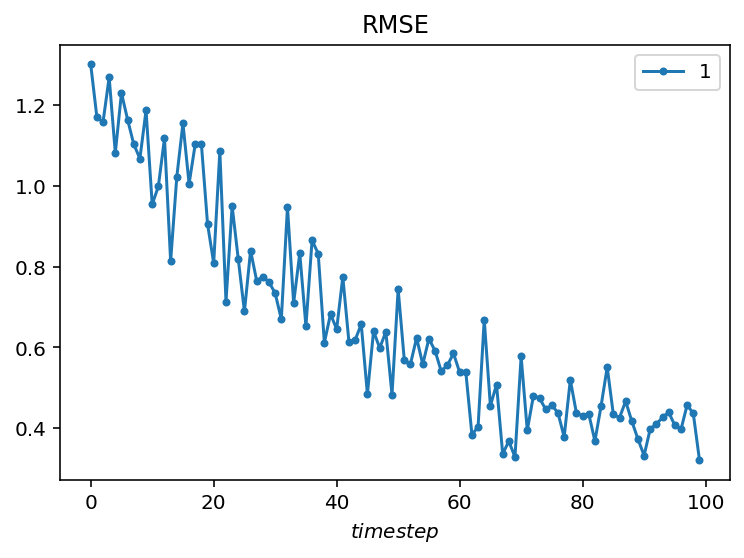

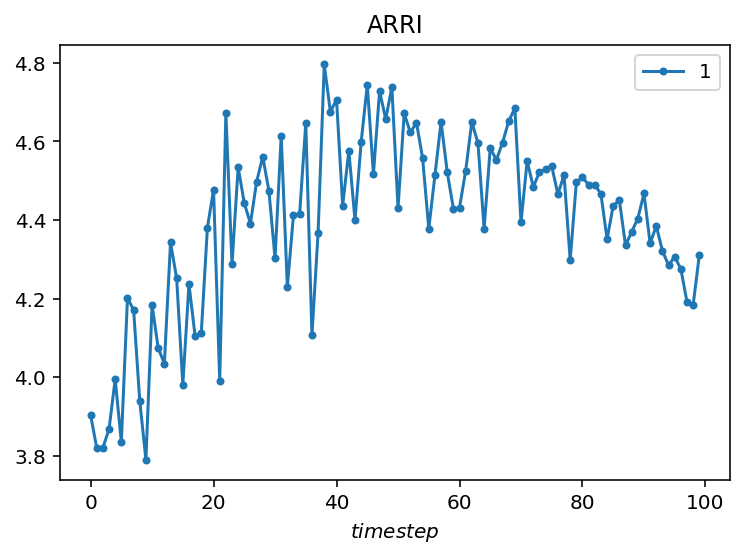

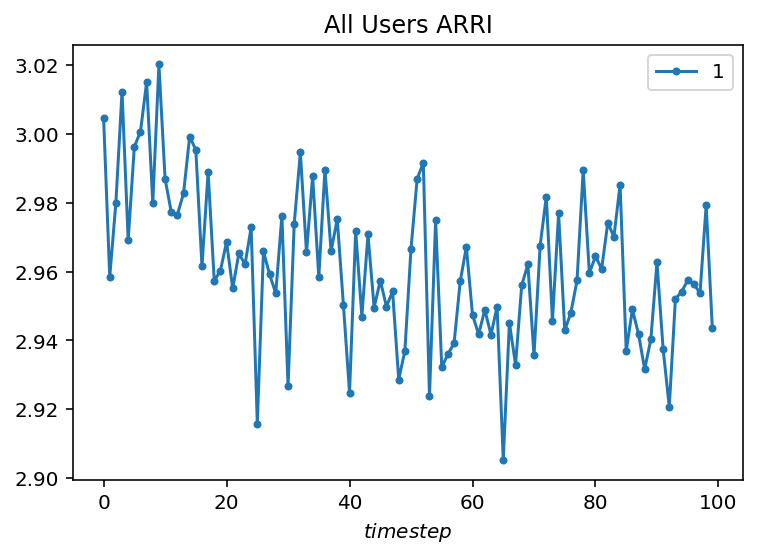

In [16]:
plot_graphs(rmses, title="RMSE")
plot_graphs(arris, title="ARRI")
plot_graphs(all_usrs_arris, title="All Users ARRI")

In the next section, we will explore these results in more detail.

# Part 1

## 1.1 Dynamic preferences

So far we've considered a 'static' environment in which user preferences remain fixex and do not change over time. \
But in reality, merely exposing users to content may change their prefernces. In this section we will examine the possible effects recommendation can have on a varying user preferences---and vice-versa.

**The Topics-dynamic environment:**\
In ```Topics-dynamic```,
items are rated by users just as defined in ```Topics-static```.
However, in this setting, user preferences can change as a result of the items they are exposed to, which in our case, are the items they are recommended by the system. Here we make the assumption that exposure to topic $k \in K$ increases the user's preference for this topic, and reduces her preference for all other topics $k'\neq k$.

In particular, if at round $t$ user $u$ is recommended an item of topic $k$, then at the next round her preferences are updated to be:

$\pi_{t+1}(u, k) ← clip(\pi_t(u, k) + a),$ \\
$\pi_{t+1}(u, k') ← clip(\pi_t(u, k') - \frac{a}{K-1}) \quad \forall k' \neq k$

where $a$ is a fixed *affinity* parameter. 

**Question**: What is the role of $a$? How do you expect various levels of $a$ to effect behavior?

**Answer**:\
The role of $a$ is to increase/decrease the users preferences according to the topic of the recommended item.\
First, I expect $a$=0 to have no effect (same as Topics-static).
Second, in general, I expect $a$ to create a bias towards giving high rating, since all items of the recommended topic will increase thier preferences more than items of other topics decreases them.\
For example, with $a$=2, all items of topic k will increase thier preferences by 2, but the others will decrease thier preferences by approx. 0.22.\
Furthermore, I expect large values to make the env's variability greater over the simulation time, since all users all items preferences will change frequently.\
Also I expect the RMSE to increase over time, since at each iteration the recommneder is being trained on an out ou date information - last iteration users ratings. The ARRI on the other hand, can be improved and can suffer from diminishing returns. It's hard to say which more.\
For example: say the user gave low rating to recommended item x. With high $a$, for the next iteration, user's preference of the item increased dramaticly, and his 'real' favorable item only slightly decreased. Next time the recommender will get to recommend to that user, he won't recommend again on the previous item although now it has high preference. Instead the recommender may recommend the other item, which had high preferences, but now will provide lower rating.

### 1.1.1 Training once
Since users preferences are bound to change over time, it may seem appealing to employ **retraining** (this is what we did in the introductory exercise above).
But before we explore how retraining dynamics behave in the the current environment, let's see what happens when we train only once at the beggining, and keep the model fixed from that point onwards.

Run a simulation with for three affinity values, $a \in \{0, 1, 2\}$,
to study:
* a static environment ($a=0$),
* a moderately dynamic environment ($a=1$), and
* a highly dynamic environment ($a=2$)

Run each simulation for a $100$ timesteps. Train the model once at the beggining, but **do not** retrain it after each round.
plot and compare two performance measures: RMSE, and average rating of recommended items (*ARRI*). Provide one figure for each measure, and plot together the results of all three simulations (i.e., for all three values of $a$ (use the provided ``plot_graphs`` function).

**Notes**:
* The argument to ``Topics`` corresponding to $a$ is called ``topic_change`` (see the documentation).
* In order to disable retraining, run ``simulation`` with the ``retrain`` argument set to ``False``.
* If you feel your results are noisy, run the experiments multiple times (using different randomization seeds) and plot average results.

Running Env with Affinity 0 repeat 0


100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Running Env with Affinity 0 repeat 1


100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Running Env with Affinity 0 repeat 2


100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Running Env with Affinity 0 repeat 3


100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Running Env with Affinity 0 repeat 4


100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Running Env with Affinity 0 repeat 5


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Running Env with Affinity 0 repeat 6


100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Running Env with Affinity 0 repeat 7


100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Running Env with Affinity 0 repeat 8


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Running Env with Affinity 0 repeat 9


100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Running Env with Affinity 1 repeat 0


100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Running Env with Affinity 1 repeat 1


100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Running Env with Affinity 1 repeat 2


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Running Env with Affinity 1 repeat 3


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Running Env with Affinity 1 repeat 4


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Running Env with Affinity 1 repeat 5


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Running Env with Affinity 1 repeat 6


100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Running Env with Affinity 1 repeat 7


100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Running Env with Affinity 1 repeat 8


100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Running Env with Affinity 1 repeat 9


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Running Env with Affinity 2 repeat 0


100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Running Env with Affinity 2 repeat 1


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Running Env with Affinity 2 repeat 2


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Running Env with Affinity 2 repeat 3


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Running Env with Affinity 2 repeat 4


100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Running Env with Affinity 2 repeat 5


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Running Env with Affinity 2 repeat 6


100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Running Env with Affinity 2 repeat 7


100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Running Env with Affinity 2 repeat 8


100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Running Env with Affinity 2 repeat 9


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


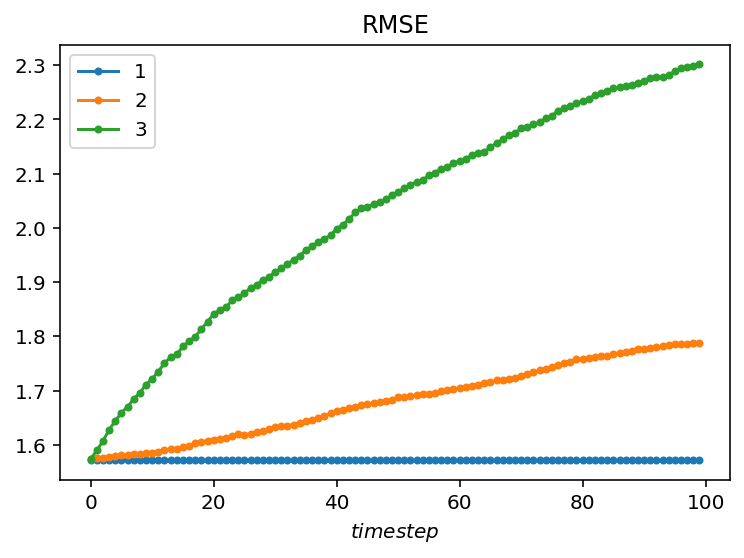

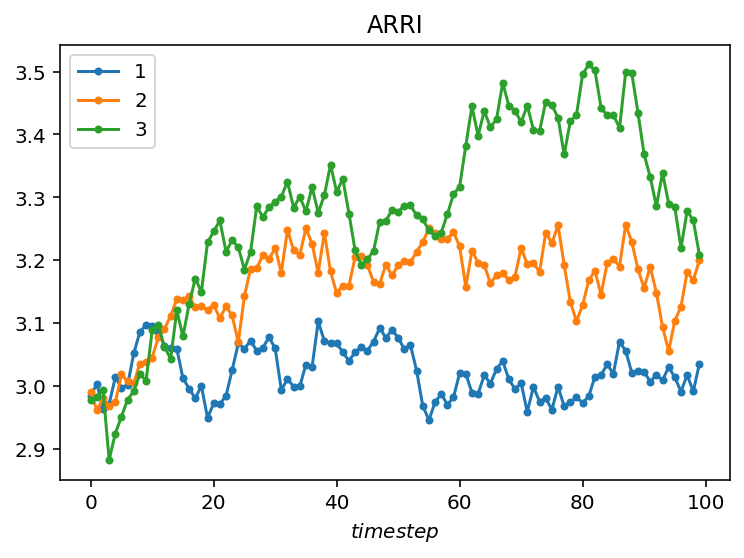

In [17]:
NUM_USERS = 100
NUM_ITEMS = 100

STEPS = 100
REPEATS = 10

env_params = {
    "num_topics": 10,
    "num_users": NUM_USERS,
    "num_items": NUM_ITEMS,
    "rating_frequency": 0.2,
    "num_init_ratings": NUM_USERS*NUM_ITEMS//100
}

callbacks = [RMSE, avg_rec_rating]

rmses = {
    0: [],
    1: [],
    2: []
}
arris = {
    0: [],
    1: [],
    2: []
}

for a in [0, 1, 2]:
  env_params['topic_change'] = a
  env = Topics(**env_params)
  for r in range(REPEATS):
    print(f'Running Env with Affinity {a} repeat {r}')
    _results = simulation(env, recommender, steps=STEPS, callbacks=callbacks, retrain=False, reset=True, seed=r)
    _rmses = _results[0]
    _arris = _results[1]
    rmses[a].append(_rmses)
    arris[a].append(_arris)

mean_rmses = {
    0: [],
    1: [],
    2: []
}
mean_arris = {
    0: [],
    1: [],
    2: []
}
for a in [0, 1, 2]:
  mean_rmses[a] = list(np.mean(np.asarray(rmses[a]), axis=0))
  mean_arris[a] = list(np.mean(np.asarray(arris[a]), axis=0))

mean_rmses_vals = list(mean_rmses.values())
mean_arris_vals = list(mean_arris.values()) 
plot_graphs(*mean_rmses_vals, title="RMSE")
plot_graphs(*mean_arris_vals, title="ARRI")

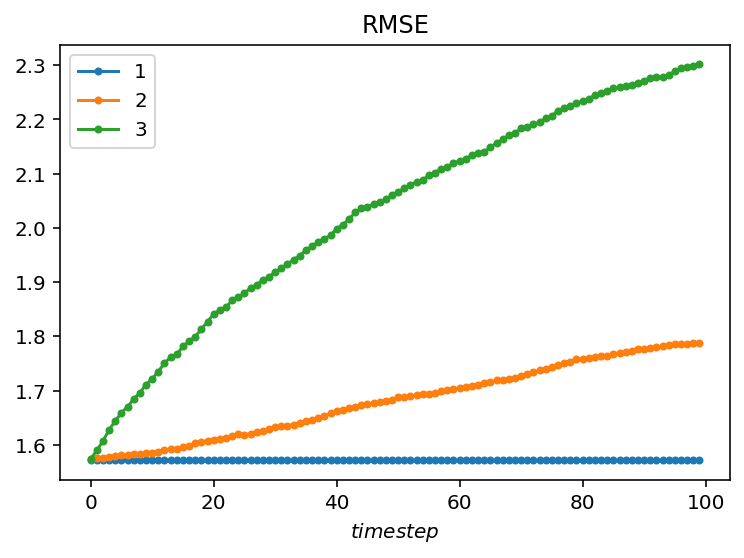

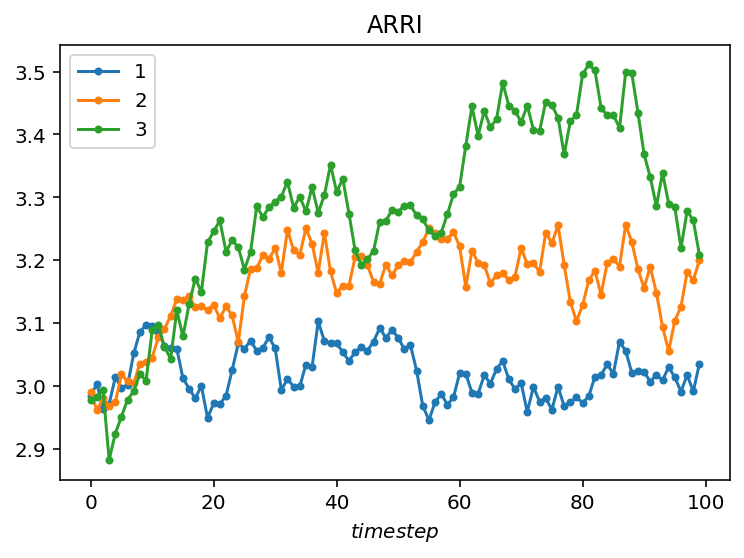

In [18]:
plot_graphs(*mean_rmses_vals, title="RMSE")
plot_graphs(*mean_arris_vals, title="ARRI")

**Explain your results**.
* Explain the trends you observe.
* What causes differences in RMSE?
* What causes differences in ARRI?
* Are results comparable across the different conditions?

**Answer:**
* For $a$=0, the environment is static and hence its statistics are not changing during simulations. Sinece here the recommender is not changed suring simulation too, RMSE is fixed. For $a$=1 / $a$=2, we observe the effects of shift/drift which harm the predictive performance of the model.
* We see that for $a$=0, ARRI stays roughly fixed, which makes sense, since the recommender does not change during the simulation, and so the environment. For $a$>0, we see that we receive what could be considered as better results, users walfare wise. But I think it is actually a kind of bias towards previous recommended topics, since the users change thier preferences in favor of previous recommendations.
* I think values of $a$ greater than 0 are comprable, but the static condition is really completely different story. We can observe it both in the predictive performance measure and the ARRI measure.

### 1.1.2 Retraining 
Next, we will explore what happens when the recommender is retrained after each round, and compare this to the single training setting above.

Repeat the experiment described in Sec. (1.1.1), but this time, enable retraining.  Plot the RMSE and ARRI graph for all three experimental conditions. Plot all three of the RMSE graphs the same figure and all three of the average ratings on the same figure (using ```plot_graphs```).

Running Env with Affinity 0 repeat 0


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Running Env with Affinity 0 repeat 1


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Running Env with Affinity 0 repeat 2


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Running Env with Affinity 0 repeat 3


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Running Env with Affinity 0 repeat 4


100%|██████████| 100/100 [00:18<00:00,  5.41it/s]


Running Env with Affinity 0 repeat 5


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Running Env with Affinity 0 repeat 6


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Running Env with Affinity 0 repeat 7


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Running Env with Affinity 0 repeat 8


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Running Env with Affinity 0 repeat 9


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Running Env with Affinity 1 repeat 0


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Running Env with Affinity 1 repeat 1


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Running Env with Affinity 1 repeat 2


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Running Env with Affinity 1 repeat 3


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Running Env with Affinity 1 repeat 4


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


Running Env with Affinity 1 repeat 5


100%|██████████| 100/100 [00:18<00:00,  5.38it/s]


Running Env with Affinity 1 repeat 6


100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


Running Env with Affinity 1 repeat 7


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Running Env with Affinity 1 repeat 8


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Running Env with Affinity 1 repeat 9


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Running Env with Affinity 2 repeat 0


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Running Env with Affinity 2 repeat 1


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Running Env with Affinity 2 repeat 2


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Running Env with Affinity 2 repeat 3


100%|██████████| 100/100 [00:18<00:00,  5.36it/s]


Running Env with Affinity 2 repeat 4


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Running Env with Affinity 2 repeat 5


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Running Env with Affinity 2 repeat 6


100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


Running Env with Affinity 2 repeat 7


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


Running Env with Affinity 2 repeat 8


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Running Env with Affinity 2 repeat 9


100%|██████████| 100/100 [00:18<00:00,  5.43it/s]


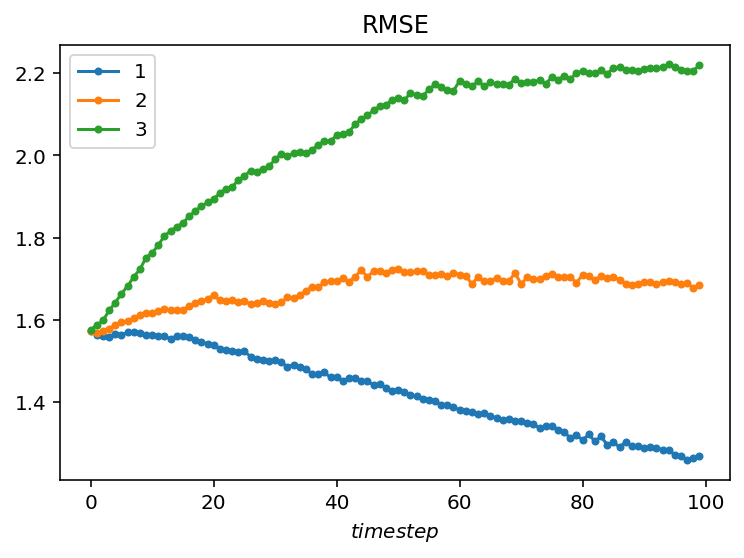

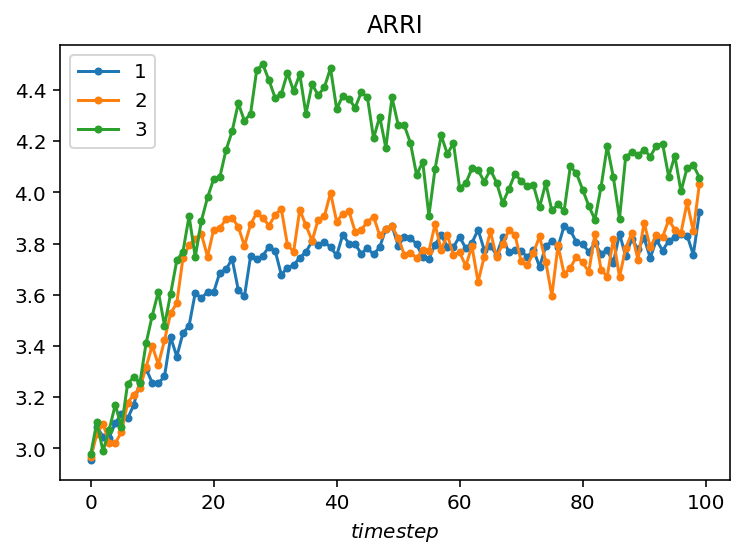

In [19]:
NUM_USERS = 100
NUM_ITEMS = 100

STEPS = 100
REPEATS = 10

env_params = {
    "num_topics": 10,
    "num_users": NUM_USERS,
    "num_items": NUM_ITEMS,
    "rating_frequency": 0.2,
    "num_init_ratings": NUM_USERS*NUM_ITEMS//100,
}

callbacks = [RMSE, avg_rec_rating]

rmses_retrain = {
    0: [],
    1: [],
    2: []
}
arris_retrain = {
    0: [],
    1: [],
    2: []
}

for a in [0, 1, 2]:
  env_params['topic_change'] = a
  env = Topics(**env_params)
  for r in range(REPEATS):
    print(f'Running Env with Affinity {a} repeat {r}')
    _results = simulation(env, recommender, steps=STEPS, callbacks=callbacks, retrain=True, reset=True, seed=r)
    _rmses = _results[0]
    _arris = _results[1]
    rmses_retrain[a].append(_rmses)
    arris_retrain[a].append(_arris)

mean_rmses_retrain = {
    0: [],
    1: [],
    2: []
}
mean_arris_retrain = {
    0: [],
    1: [],
    2: []
}
for a in [0, 1, 2]:
  mean_rmses_retrain[a] = list(np.mean(np.asarray(rmses_retrain[a]), axis=0))
  mean_arris_retrain[a] = list(np.mean(np.asarray(arris_retrain[a]), axis=0))

mean_rmses_retrain_vals = list(mean_rmses_retrain.values())
mean_arris_retrain_vals = list(mean_arris_retrain.values()) 
plot_graphs(*mean_rmses_retrain_vals, title="RMSE")
plot_graphs(*mean_arris_retrain_vals, title="ARRI")

**Explain your results**.
* Explain the trends you observe. Do they match your expectations?
* What causes differences in RMSE? And in ARRI?
* How can you tell? *Can* you tell?

**Answer:**
* With the static environment ($a$=0), we see the predictive performance measure (RMSE) drops, which as in per with our expectations, since the enviroment statistics are not changing, but the recommender does, which allow him to approximate each user preferences better.\
With the two flavors of dynamic environments, we see a degredations in the predictive performances, for $a$=1 the recommender almost succeed to learn fast enough to keep the predictive perfomance measure roughly fixed, but with $a$=2 the env is changing too fast to keep up.\
Regarding the ARRI, the most obvious trend here is that with the most dynamic env, the ARRI is better than the others. This is not what I expected, but can be explained by the fact that the env is drift in the 'general direction' of the recommender recommendations.
* While we can tell why the RMSE is being improved/worst, I think it is impossible to tell when and why the ARRI will be better/worst, since it is a loop feedback system. 

### 1.1.3 Comparison
Create a plot that compares training vs. not training in terms of **RMSE** for each $a$ value (use your results 1.1.1 and 1.1.2). Is there a general trend? Explain.

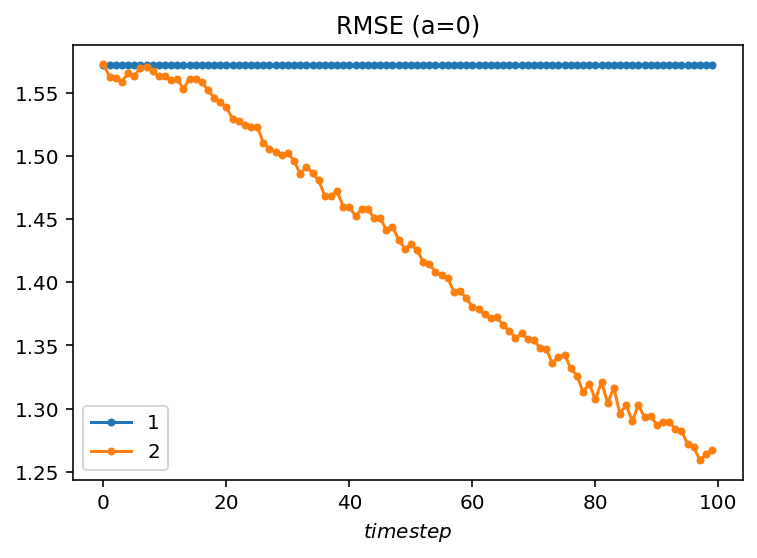

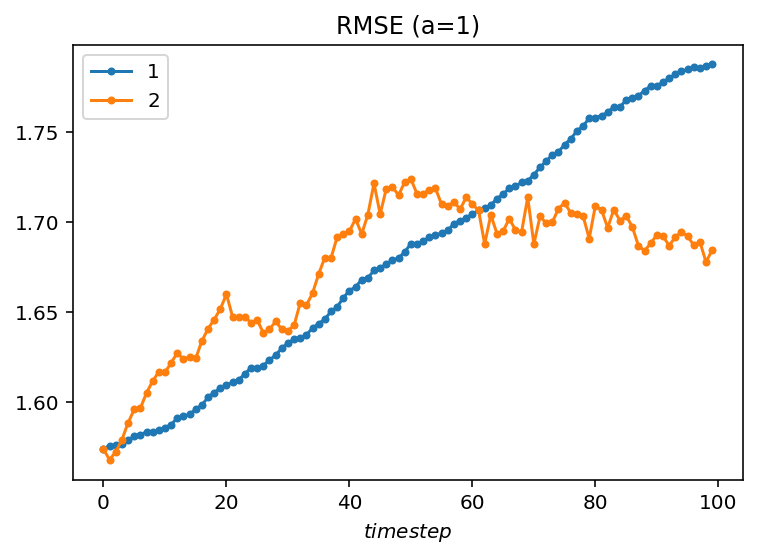

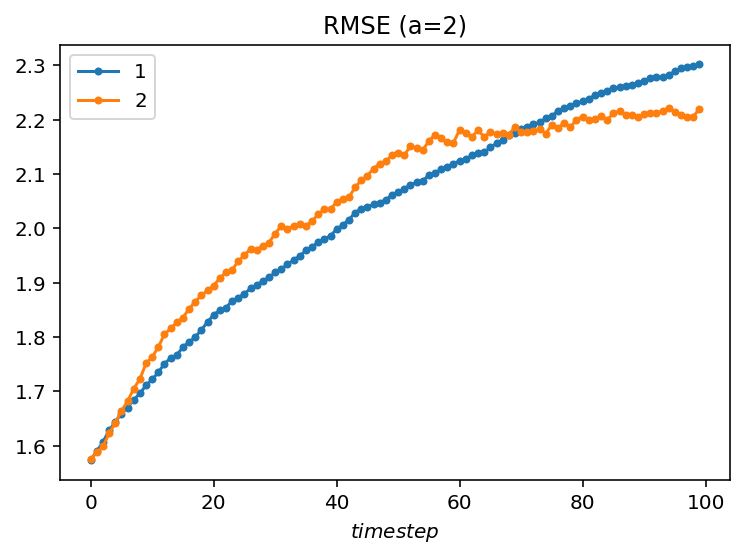

In [20]:
for i, a in enumerate([0, 1, 2]):
  plot_graphs(*[mean_rmses_vals[i], mean_rmses_retrain_vals[i]], title=f"RMSE (a={a})")

**Answer:**\
The trend is as the env become more dynamic, the RMSE of a static recommender converges with the RMSE of a dynamic recommender. 

Now, create a plot that compares training vs. not training in terms of **ARRI** for each $a$ value (use your results 1.1.1 and 1.1.2). Is there a general trend? Explain.

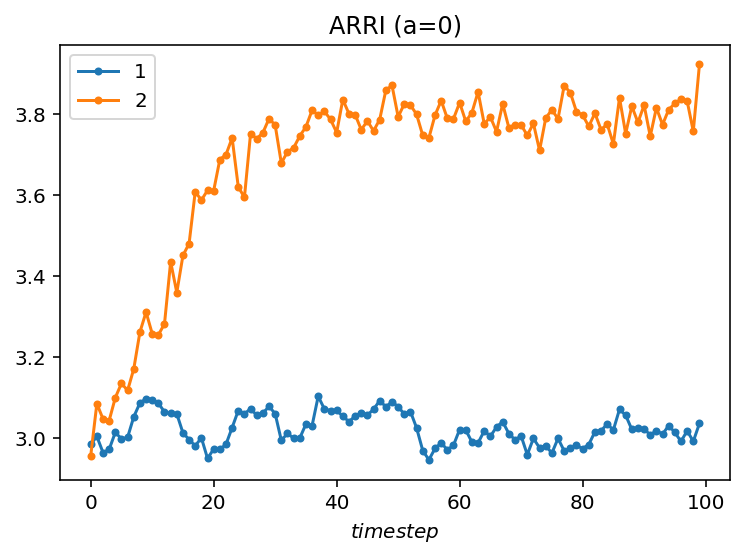

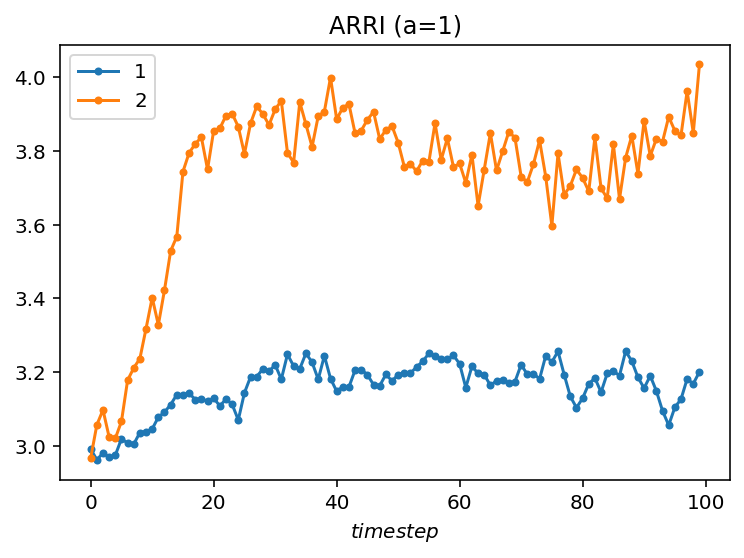

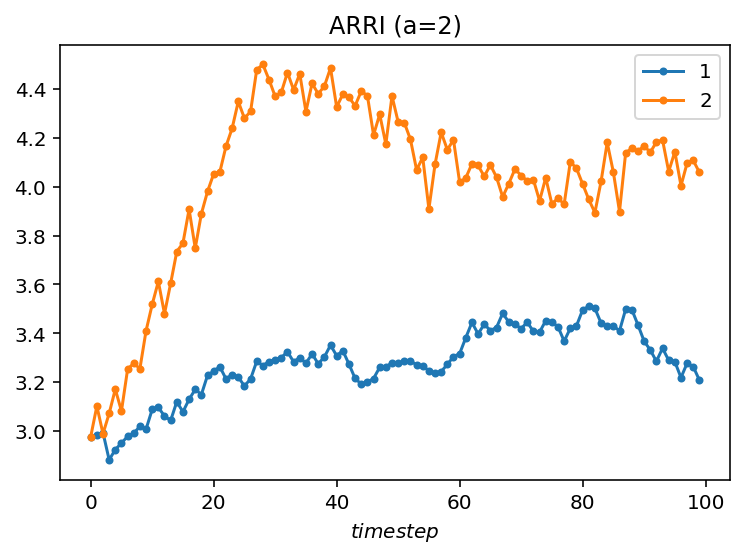

In [21]:
for i, a in enumerate([0, 1, 2]):
  plot_graphs(*[mean_arris_vals[i], mean_arris_retrain_vals[i]], title=f"ARRI (a={a})")

**Answer**:\
I think that for the static recommender there is no trend. for all conditions the ARRI stays roughly the same, for the dynamic envs, it is increased a little bit, but not a dramatic change (from ~3 up to ~3.5).\
For the dynamic recommender (the one which is being retrained), the ARRI is roughly the same for the static env and the little dynamic env, but is improved dramatically with the hard dynamic env (from ~4 to ~4.75) before it drops to the same end value. 

### 1.1.4 Conclusions
Retraining is an **intervention** - it can potentially improve outcomes, but once applied, inevitabely also affects measurements. This makes it difficult to attribute observed effects (e.g., improved ratings) to learning (rather than to, e.g., changes in user preferences).

**Explain the paractical implications of this idea.**

**Answer**:\
The practical implication of this idea is that it is hard to impossible to quantify the performance of our learner. how can we tell whether our learning process is 'good' or the env jsut accidently moved to the direction of high rating lately, and it has nothing to do with us. Furthermore, it could more to some direction because of us, and how can wed tell if this is the optimal point, or just some sort of 'pygmalion effect'?

## 1.2 Social effects

In this section we will explore certain social effects that recommendations can cause. For this, we will use two callback functions, each simulating the recommendation of a single item to each user,
and providing information regarding these recommendations. The callbacks are:
1. ``get_topics_recommended_items``: returns a list of the topics of the recommended items.
2. ``get_all_users_avg_rating_of_recommended_items``: returns the average rating of recommended items across *all* users (\*)

Use these callbacks AND the ```avg_rec_rating``` callback (total of 3 callbacks) as input to ```simulation``` to gather information that will be useful for studying social effects.

(\*) In contrast to ARRI, this callback does *not* return the rating of the user for which the item was recommended; rather, it returns the average ratings across *all* users, *had* they been recommended this item. This is of course counterfactual - in reallity the system has no access to this sort of information.

### 1.2.1 Simulating
Run retraining simulations, similarly to those in Sec. 1.1, under **two experimental conditions**:
* once with $a=0$ as a baseline **static** environment, and
* once with $a=2$ representing a **dynamic** environment.

Run both simulations with the two callbacks above, as well as with the ``avg_rec_rating`` callback.

In [22]:
NUM_USERS = 100
NUM_ITEMS = 100#200
STEPS = 100
REPEATS = 10

callbacks = [get_topics_of_recommended_items, get_all_users_avg_rating_of_recommended_items, avg_rec_rating]

env_params = {
    "num_topics": 10,
    "num_users": NUM_USERS,
    "num_items": NUM_ITEMS,
    "rating_frequency": 0.2,
    "num_init_ratings": NUM_USERS*NUM_ITEMS//100
}

arris = {
    0: [],
    2: []
}
rec_topics = {
    0: [],
    2: []
}
all_usrs_arris = {
    0: [],
    2: []
}

for a in [0, 2]:
  env_params['topic_change'] = a
  env = Topics(**env_params)
  for r in range(REPEATS):
    print(f'Running Env with Affinity {a} repeat {r}')
    _results = simulation(env, recommender, steps=STEPS, callbacks=callbacks, retrain=True, reset=True, seed=r)
    _rec_topics = _results[0]
    _all_usrs_arris = _results[1]
    _arris = _results[2]
    rec_topics[a].append(_rec_topics)
    all_usrs_arris[a].append(_all_usrs_arris)
    arris[a].append(_arris)

mean_arris = {
    0: [],
    2: []
}
mean_rec_topics = {
    0: [],
    2: []
}
mean_all_usrs_arris = {
    0: [],
    2: []
}

for a in [0, 2]:
  mean_arris[a]          = list(np.mean(np.asarray(arris[a]), axis=0))
  mean_all_usrs_arris[a] = list(np.mean(np.asarray(all_usrs_arris[a]), axis=0))

Running Env with Affinity 0 repeat 0


100%|██████████| 100/100 [00:36<00:00,  2.78it/s]


Running Env with Affinity 0 repeat 1


100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


Running Env with Affinity 0 repeat 2


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Running Env with Affinity 0 repeat 3


100%|██████████| 100/100 [00:35<00:00,  2.79it/s]


Running Env with Affinity 0 repeat 4


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Running Env with Affinity 0 repeat 5


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 0 repeat 6


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 0 repeat 7


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Running Env with Affinity 0 repeat 8


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Running Env with Affinity 0 repeat 9


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 2 repeat 0


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Running Env with Affinity 2 repeat 1


100%|██████████| 100/100 [00:35<00:00,  2.80it/s]


Running Env with Affinity 2 repeat 2


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Running Env with Affinity 2 repeat 3


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 2 repeat 4


100%|██████████| 100/100 [00:35<00:00,  2.83it/s]


Running Env with Affinity 2 repeat 5


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 2 repeat 6


100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


Running Env with Affinity 2 repeat 7


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 2 repeat 8


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


Running Env with Affinity 2 repeat 9


100%|██████████| 100/100 [00:35<00:00,  2.82it/s]


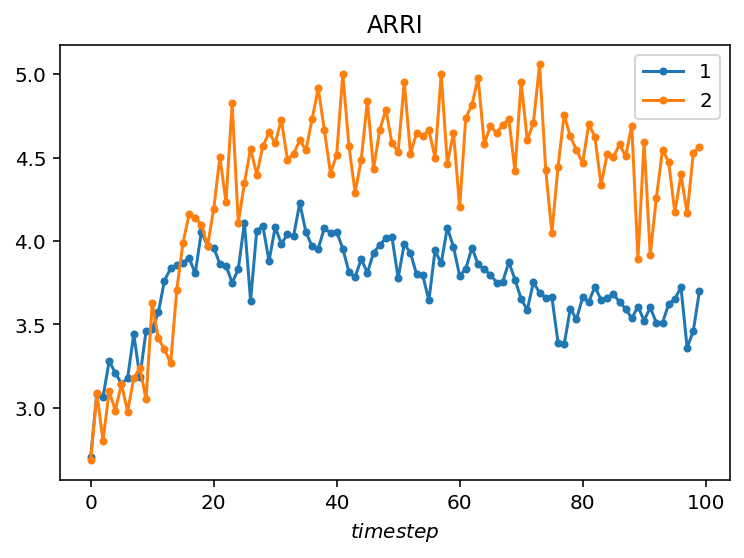

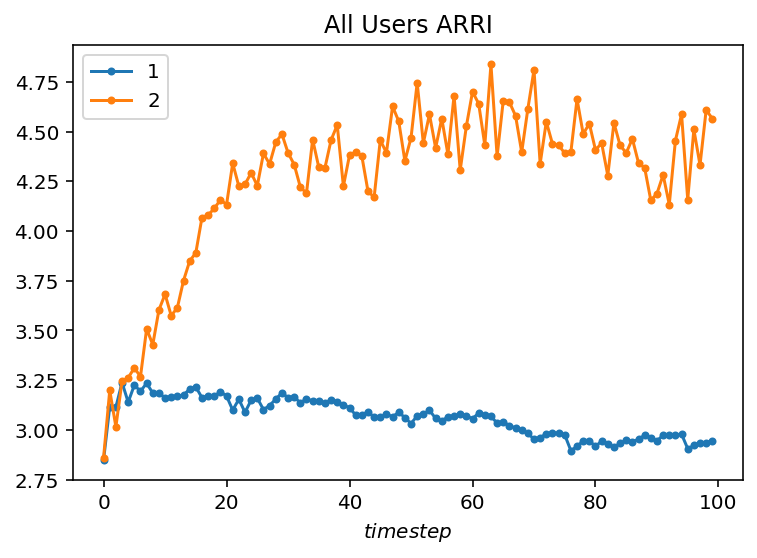

In [23]:
plot_graphs(*[list(arris.values())[0][0], list(arris.values())[1][0]], title="ARRI")
plot_graphs(*[list(all_usrs_arris.values())[0][0], list(all_usrs_arris.values())[1][0]], title="All Users ARRI")

### 1.2.2 Topic histograms
Now, for each condition, **plot two histograms** (so four histograms total) counting the number of times each topic was recommended:
* once as measured in the beggining of the simulation - take the sum counts over the 10 initial rounds (i.e., $t=1,...,10$), and
* once at the end - take the sum over the 10 last rounds (i.e., $t=91,...,100$)

**Tip:** use your callbacks.

Make sure to use the same y-axis range across plots for a proper comparison (use ``matplotlib``'s ``ylim`` argument).

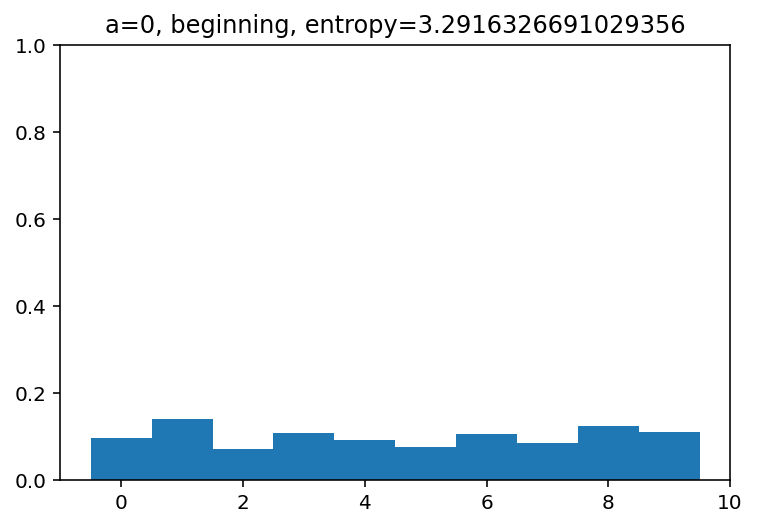

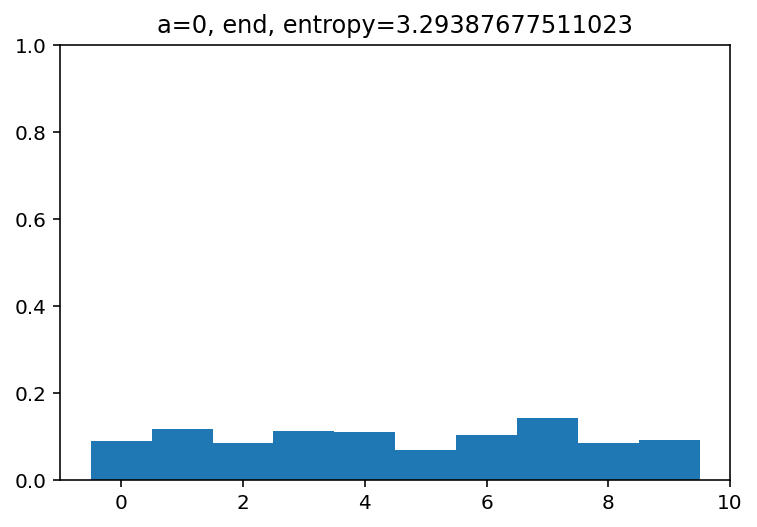

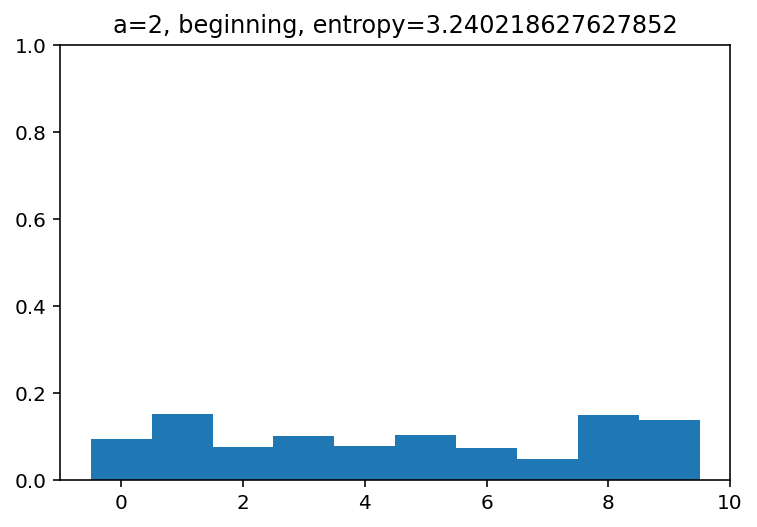

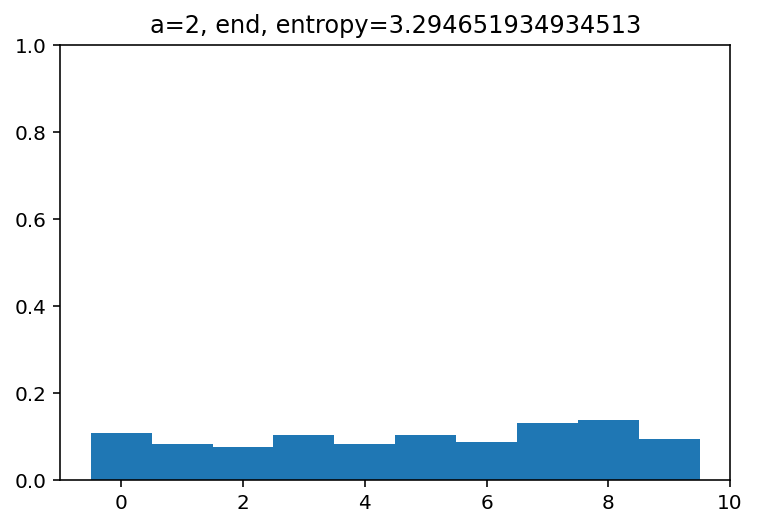

In [24]:
import pandas as pd
from matplotlib import pyplot as plt 
from scipy.stats import entropy

for a in [0, 2]:
  # _arr = np.concatenate(rec_topics[a][0][:10])
  _arr = np.concatenate([rec_topics[a][i][:10] for i in range(len(rec_topics[a]))]).flatten()
  hist, _ = np.histogram(_arr, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
  plt.hist(_arr, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], density=True)
  plt.ylim(0, 1)
  plt.title(f'a={a}, beginning, entropy={entropy(hist/np.sum(hist), base=2)}')
  plt.show()
  # _arr = np.concatenate(rec_topics[a][0][-10:])
  _arr = np.concatenate([rec_topics[a][i][-10:] for i in range(len(rec_topics[a]))]).flatten()
  hist, _ = np.histogram(_arr, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5])
  plt.hist(_arr, bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], density=True)
  plt.ylim(0, 1)
  plt.title(f'a={a}, end, entropy={entropy(hist/np.sum(hist), base=2)}')
  plt.show()

**Explain your results**.
* How do the different conditions comapare at the beginning?
* How do the different conditions comapare at the end?
* What social effect do you obsreve here? Can you name it?

**Answer:**
* At the beginning the static env is less uniform than the dynamic env (as can be measured by the entropy of the histogram, interpreted as probabilities, rather than counts). Notably, one class has more weight than the others, in both conditions. 
* The same Phenomenon obsereved at the end. But now there is no 'heavier' class than others. 
* I would say that in the beginning we observe a low diversity bias of the recommender at the beginning, which is being eliminated as the simulation progress.
(didn't happen after running 10 times & averaged...)

### 1.2.3 Ratings over time
For each condition, **plot the average rating of recommended items** (ARRI; return values from ```avg_rec_ratings```) as they change over rounds. Remeber - these are the ratings of the users to whom the items were recommnded.

Again, make sure to use matching y-axis ranges.

Now, for each condition, **plot the average rating of recommended items across all users** (return values from ```get_avg_rating_of_recommended_items```) as they change over rounds.
Remember - these describe ratings of recommended items, but are not the ratings of the specific users to whom the items were recommended.

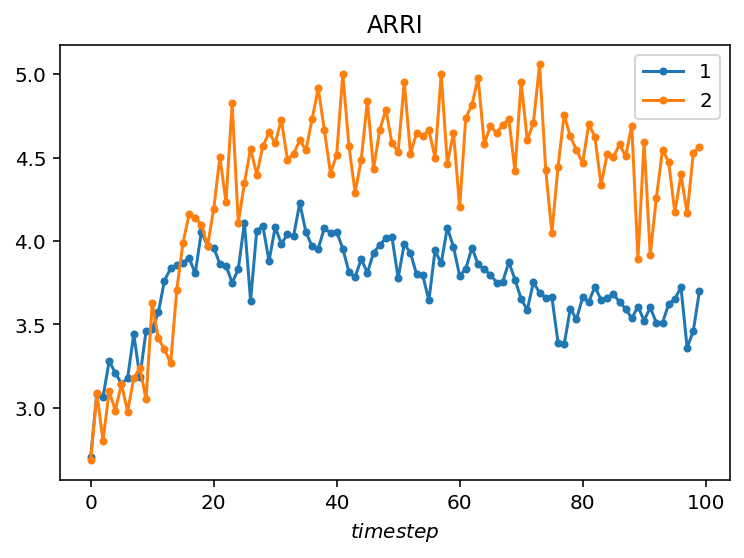

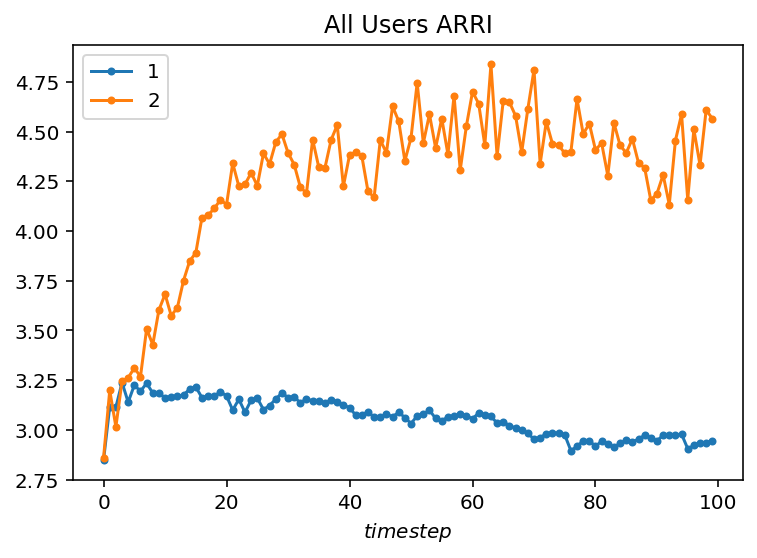

In [25]:
plot_graphs(*[list(arris.values())[0][0], list(arris.values())[1][0]], title="ARRI")
plot_graphs(*[list(all_usrs_arris.values())[0][0], list(all_usrs_arris.values())[1][0]], title="All Users ARRI")

**Explain your results**.
* Explain the trends you see. Compare within and across conditions (different $a$) and measurements (ARRI vs. ratings for all users).
* What social effect do you obsreve here? Can you name it?

# Part 2

**General guidlines:** This section is *exploratory* - you are encouraged to think, experiment, and try out different approaches. Concentrate on thinking things through and proposing a sound idea (worry more about what you propose, and less about whether it works exactly as expected or not). Be creative!

## 2.1 Fighting feedback using one-step “lookahead”

As we've seen so far in this workshop, recommendation is a dynamic process that is prone to feedback effects, due both to the actions of the system (e.g., retraining) and the behavioral tendencies of users (e.g., preference change with exposure, susceptibility to social signals). Feedback can sometimes help, but at other times - can promote undesired outcomes, either in terms of performance (predictive or recommendation qulity) or other important aspects (homogenization, echo chambers, filter bubbles, etc.).

Ideally, learning to recommend should be done in a way that takes feedback into account and optimizes various criteria for the *long term*. However, this is an exceptionally challenging task. One milder alternative is to instead use a greedy approach and recommend in a way that considers the effects of recommendation only **one time-step ahead**.

The idea here is for the system--*before* it recommends--to simulate how users are likely to act in response to recommendations. By "looking ahead" one step into the future, and by anticipating user responses, the system can in principal be smarter about what it plans to recommend, ideally in a way that compensates for any possible negative affects.

In reallity, the system must "guess" how users will act in the next timestep. In this exercise, we will make life easier for you, and allow you to use the simulation environment itself to simulate what will happen next. This will focus the challenge on planning ahead correctly (rather than on estimating user responses). Technically, do this using ``copy.deepcopy(env)`` - this copies the environment and lets you perform a simulated step on it, without affecting the natural flow of the simulation itself.
    

### 2.1.1 Choose your problem

**Plan ahead!** Begin by deciding what negative effect of prediction-only recommendation you wish to combat using a lookahead strategy. This could be one of the effects we've discussed above (predictive performance, ratings/welfare, homogenization/diversity, popularity/fat-tails, echo-chambers), mentioned in class (filter bubbles, polarization), or something else (ask us!).

Then, choose ``environment`` and ``recommender`` classes that you feel are appropriate for working with the effect you've chosen. Think carefully about what properties these should have for you to (i) observe the effect, and (ii) be able to mitigate it.

Finally, determine how you will need to extend ``environment`` and ``recommender`` to support your experimental setup. For example, you may need to control user preferences, update stored data, or (re)train the model in certain ways. Ideally, these should be implemented as callbacks (this may not always be possible, but will certainly make things easier for you). 

**Write these down:**

* **Chosen effect**: Echo Chambers in social cycles. I'm not sure - maybe it's not the classic meaning we spoke in class about.\
The problem I want to mitigate is the tendency of cycles of people to change thier behavior based on a single recommendation arrive to any one of them.\
For example, when a friend of mine gets a recommendation from Netflix and tell me about it, it has an impcat on **my** future decisions.\
I think it will create some sort of Popolarity Bias towards the first recommendations the recommender gives (which are chosen ralmost randomly).

* **Environment**: Basically it's an extension to Topics-dynamic.
I will add the concept of 'social cycles' to the users-items matrix.
  1. I will divide the users to M groups (cycles). Each grous is hypothesised as a 'group of friends'.
  2. After each time a recommendation is received, not only the specific active user who got the recommendation update his preferences, but also all his friends. 
  3. The preferences itself are still subject to updates according to the same rule as before.
  4. on the evaluation step, I will be able to evaluate different sizes of cycles (from a single cycle - all users are friends and observe each other recommendations - to a sociopath society where each user only observe 'his' recommendations).\
    4.1 I will also be able to simulate a weaker impact on 'friends of an active user'. This is make sense, for example back in the Netflix case, when a friend of mine gets a recommendation and tell me about it, it has a lower impcat on my future decisions compared to the case if I would get the recommendation myself directly.
    4.2 On another thought, the sociopath society is axactly what we had in the previous examples in this Workshop... 😰 What does it means about you guys?

* **Recommender**: I don't see any specific change needed for the recommender.

* **Callbacks**: True Ratings in the next step simulation on the same active users / all users (all users soumds too cheaty to be honest).


**Briefly explain your choices:**

**Answer:** inline above

### 2.1.2 State your lookahead strategy

Imagine the system has just received a new batch of data, retrained on it, and is about to send recommendations to its users. What is "good" about these recomendations, and what can be "bad"? If the system had the ability to anticipate what would happen *after* it recommends - would it change its recommendations, and how?

Decide on a lookahead strategy - briefly explain:
* what you plan to look ahead for
* how you'll do this (remember you can "cheat" by using a copy of the simulation environment)
* what will you be looking for and what you will measure
* how will you use this to change your recommendations

**Answer**:
1. A new batch of active users arrive
2. The recommender recommend them new items
3. The problem is that the recommendation itself changes the preferences distribution among users-items, and therefore the training step is in the wrong / semi-wrong direction. But if the recommender gets a sample from the **new** data distiribution, he can made a better update step. 
4. So, before update the recommender, I will get the true ratings of active users / all users and measure the entropy of thier 'true chosen topic', which is the entropy of the highest rating item per user.
5. If the entropy just got higher, we are good to go. We want to make the distribution more uniform. Otherwise, we can made an exploratory step and generate a random recommendations. In principle it is similar to Eplsilon Greedy approach in exploration-exploitation trade-off, but the case when we do exploration is not random, but uses the entropy change as heuristics. 

### 2.1.3 Simulate
Create a new ```simulation_with_lookahead(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True, <any number of other arguments>)``` function, similar to the ```simulation``` function from the introduction, that simulates a recommendation system and its affect on the environment.

Implement within this function your lookahead step.

In [214]:
import copy

def get_favorable_item_topics_entropy(env, recommender=None):
  item_topics = env._item_topics
  true_ratings = env.dense_ratings
  favorable_item_topics = \
    item_topics[np.argmax(true_ratings, axis=1)]  # The topic of the most favoarble item per user (one item per user)
  favorable_item_topics_hist, _ = \
    np.histogram(favorable_item_topics, bins=[x-0.5 for x in list(range(env._num_topics+1))])
  favorable_item_topics_hist = \
    favorable_item_topics_hist/np.sum(favorable_item_topics_hist)  # Histogram (normalized) of the most beloved topics among all users
  favorable_item_topics_entropy = \
    entropy(favorable_item_topics_hist, base=env._num_topics)  # Entropy of the histogram. The lower - the higher the Popolarity Bias (more users favor a less topics)
  return favorable_item_topics_entropy

callbacks = [get_favorable_item_topics_entropy]

def simulation_with_lookahead(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True, seed=0, use_lookahead=False):
  if reset:
    env.seed(seed)
    if hasattr(env, '_topic_change'):
      temp = env._topic_change # Specificaly for topics.
      env._topic_change = 0
      items, users, ratings = env.reset()
      env._topic_change = temp
    elif hasattr(env, '_affinity_change '):
      temp = env._affinity_change  # Specificaly for latent factor.
      env._affinity_change = 0
      items, users, ratings = env.reset()
      env._affinity_change = temp
    else:
      items, users, ratings = env.reset()
    
    recommender.reset(items, users, ratings)

  results = None
  if callbacks is not None:
    results = [[] for _ in callbacks]
    
  for i in tqdm(range(steps)):
    if callbacks is not None:
      for j, callback in enumerate(callbacks):
        res = callback(env, recommender)
        results[j].append(res)

    online_users = env.online_users
    """
    --------------------------------------------------
    Lookahead step here.
    Hint: You can use 'copy.deepcopy(env)' to copy the
    environment and perform a simulated step on it.
    --------------------------------------------------
    """
    recommendations, predicted_ratings = recommender.recommend(online_users, rpu)
    
    if use_lookahead:
      env_copy = copy.deepcopy(env)
      # Check how our current recommendations impact the users (their true ratings on the next step)
      env_copy.step(recommendations)
      next_step_true_ratings = env_copy.dense_ratings
      next_step_item_topics = env_copy._item_topics
      next_step_favorable_items_topics = \
        next_step_item_topics[np.argmax(next_step_true_ratings, axis=1)]
      next_step_favorable_items_topics_hist, _ = \
        np.histogram(next_step_favorable_items_topics, bins=[x-0.5 for x in list(range(env_copy._num_topics+1))])
      next_step_favorable_items_topics_hist = \
        next_step_favorable_items_topics_hist/\
          np.sum(next_step_favorable_items_topics_hist)
      next_step_favorable_items_topics_entropy = \
        entropy(next_step_favorable_items_topics_hist, base=env_copy._num_topics)
      if i != 0:
        # If the entropy is lower, we are getting closer to Popolarity bias
        if next_step_favorable_items_topics_entropy < previous_step_favorable_items_topics_entropy:
          # print(f'{previous_step_favorable_items_topics_entropy}->{next_step_favorable_items_topics_entropy}')
          recommendations = np.random.randint(0, high=NUM_ITEMS-1, size=recommendations.shape)
      previous_step_favorable_items_topics_entropy = next_step_favorable_items_topics_entropy

    _, _, ratings, _ = env.step(recommendations) # This is the commit phase
    recommender.update(ratings=ratings)

    if retrain and hasattr(recommender, '_model'):
      recommender._model.train(recommender._train_data) # Specificaly for libfm.

  return results

def loop_simulation(env, recommender, steps=100, rpu=1, retrain=True, callbacks=None, reset=True, use_lookahead=False, repeats=3):
  all_results = []
  for r in range(repeats):
    print(f'Repeat {r}')
    results = simulation_with_lookahead(env, recommender, steps, rpu, retrain, callbacks, reset, seed=r, use_lookahead=use_lookahead)
    all_results.append(results)
  return all_results

### 2.1.4 Experiment
Run an experiment that compares a your lookahead approach to a myopic baseline (that does not lookahead). Think carefully about how to set up the environment and dynamics, what to measure, and how.

Plot your results, and discuss them.

In [215]:
import numpy as np
import scipy.sparse
from scipy.stats import entropy
import wpyfm
from tqdm import tqdm
import reclab
from reclab.environments import Topics
from reclab.recommenders.libfm import LibFM
from reclab.recommenders import RandomRec, TopPop, KNNRecommender, Autorec

In [216]:
NUM_USERS = 100
NUM_ITEMS = 100
NUM_STEPS = 100
NUM_REPEATS = 10
NUM_TOPICS = 10
RATING_FREQ = 0.2
NUM_INIT_RATING = NUM_USERS*NUM_ITEMS//10
TOPIC_CHANGE=10

env = Topics(
    num_topics=NUM_TOPICS,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    rating_frequency=RATING_FREQ,
    num_init_ratings=NUM_INIT_RATING,
    topic_change=TOPIC_CHANGE,
)

recommender = LibFM_MLHB(
    num_user_features=0,
    num_item_features=0,
    num_rating_features=0,
    max_num_users=NUM_USERS,
    max_num_items=NUM_ITEMS,
    seed=0
)

# results = simulation_with_lookahead(env, recommender, steps=NUM_STEPS, rpu=1, retrain=True, callbacks=callbacks, reset=True, seed=0)
results = loop_simulation(env, recommender, steps=NUM_STEPS, rpu=1, retrain=True, callbacks=callbacks, reset=True, repeats=NUM_REPEATS, use_lookahead=True)
mean_results = list(np.mean(np.asarray(results).squeeze(1), axis=0))

Repeat 0


100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Repeat 1


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Repeat 2


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Repeat 3


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Repeat 4


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Repeat 5


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Repeat 6


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Repeat 7


100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Repeat 8


100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Repeat 9


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


**Experiment 1: Baseline**
* Topics-dynamic env - no social cycles
* No lookahead use - the code is there but without use
* Entropy over the favorable item perf user is our measure for Popolarity Bias: the lower the entropy, the farther the favorable topics distribution from uniform, means, the higher the bias


In [217]:
dynamic_vals_results_wo_lookahead = {}
for dynamic_val in [0, 1, 2, 4]:
  print(f'Running Simulation with Dynamic Val {dynamic_val}')
  env = Topics(
      num_topics=NUM_TOPICS,
      num_users=NUM_USERS,
      num_items=NUM_ITEMS,
      rating_frequency=RATING_FREQ,
      num_init_ratings=NUM_INIT_RATING,
      topic_change=dynamic_val,
  )
  results_ = loop_simulation(env, recommender, steps=NUM_STEPS, rpu=1, retrain=True, callbacks=callbacks, reset=True, repeats=NUM_REPEATS)
  mean_results_ = list(np.mean(np.asarray(results_).squeeze(1), axis=0))
  dynamic_vals_results_wo_lookahead[dynamic_val] = mean_results_
  del results_
  del mean_results_

Running Simulation with Dynamic Val 0
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.75it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


Running Simulation with Dynamic Val 1
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.56it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.66it/s]


Running Simulation with Dynamic Val 2
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.84it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.68it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.70it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


Running Simulation with Dynamic Val 4
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.67it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.82it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.50it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.52it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.54it/s]


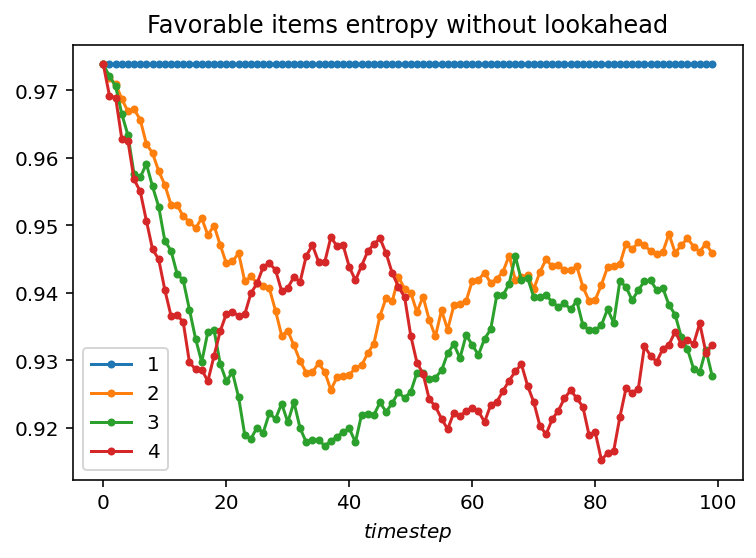

In [218]:
plot_graphs(*list(dynamic_vals_results_wo_lookahead.values()), title='Favorable items entropy without lookahead')

**Experiment 2: Baseline with entropy lookahead**
* Topics-dynamic env - no social cycles
* Lookahead use - if the entropy after current step is getting lower than previous step, make random walk recommendation.

In [219]:
dynamic_vals_results_w_lookahead = {}
for dynamic_val in [0, 1, 2, 4]:
  print(f'Running Simulation with Dynamic Val {dynamic_val}')
  env = Topics(
      num_topics=NUM_TOPICS,
      num_users=NUM_USERS,
      num_items=NUM_ITEMS,
      rating_frequency=RATING_FREQ,
      num_init_ratings=NUM_INIT_RATING,
      topic_change=dynamic_val,
  )
  results_ = loop_simulation(env, recommender, steps=NUM_STEPS, rpu=1, retrain=True, callbacks=callbacks, reset=True, repeats=NUM_REPEATS)
  mean_results_ = list(np.mean(np.asarray(results_).squeeze(1), axis=0))
  dynamic_vals_results_w_lookahead[dynamic_val] = mean_results_
  del results_
  del mean_results_

Running Simulation with Dynamic Val 0
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.61it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.57it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.60it/s]


Running Simulation with Dynamic Val 1
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.69it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.78it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.63it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


Running Simulation with Dynamic Val 2
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.44it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.79it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.59it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.58it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Running Simulation with Dynamic Val 4
Repeat 0


100%|██████████| 100/100 [00:09<00:00, 10.46it/s]


Repeat 1


100%|██████████| 100/100 [00:09<00:00, 10.72it/s]


Repeat 2


100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


Repeat 3


100%|██████████| 100/100 [00:09<00:00, 10.43it/s]


Repeat 4


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


Repeat 5


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


Repeat 6


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


Repeat 7


100%|██████████| 100/100 [00:09<00:00, 10.64it/s]


Repeat 8


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


Repeat 9


100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


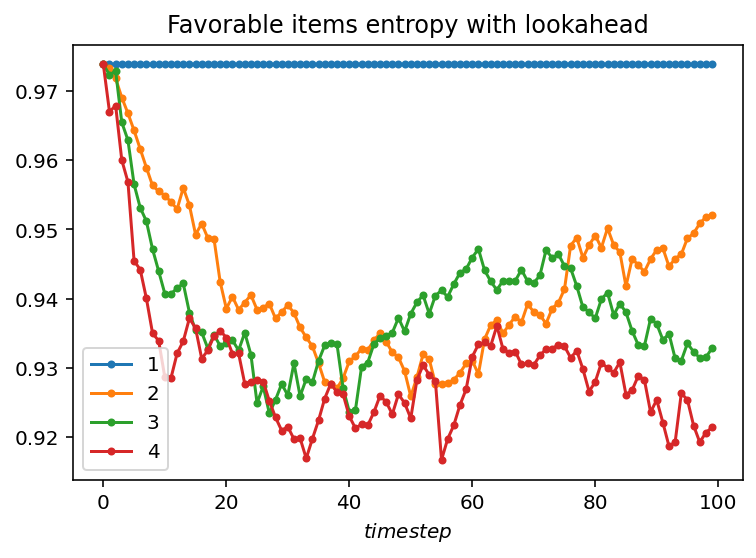

In [220]:
plot_graphs(*list(dynamic_vals_results_w_lookahead.values()), title='Favorable items entropy with lookahead')

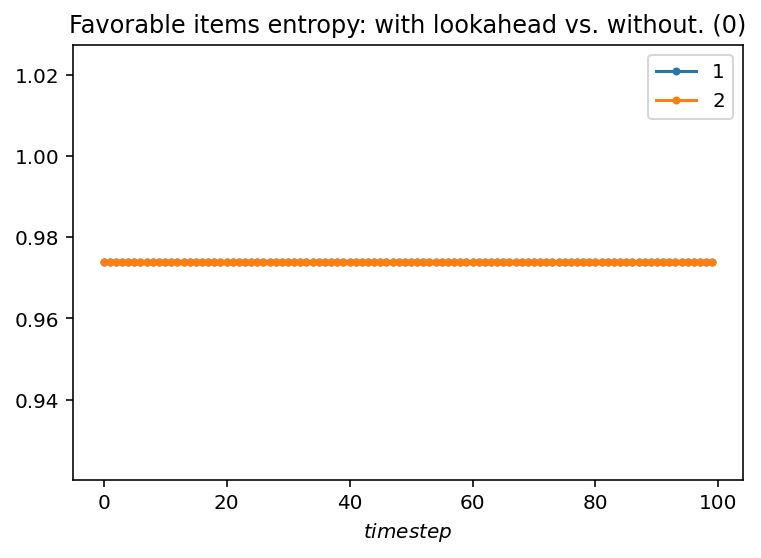

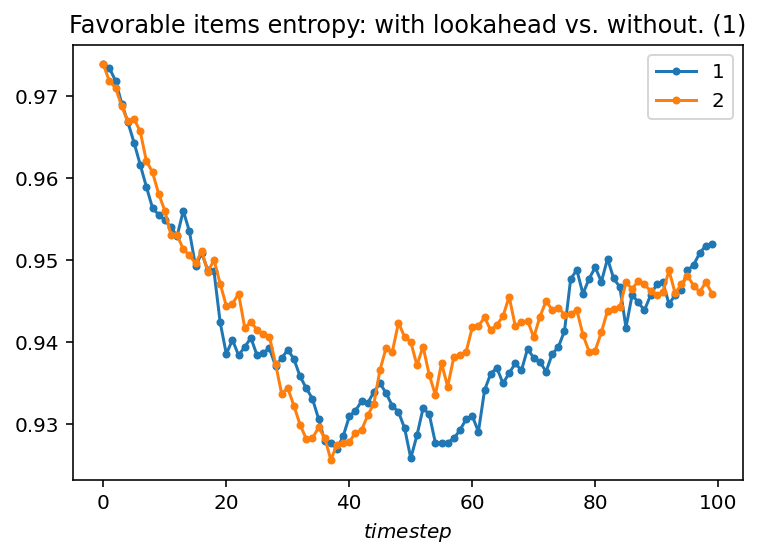

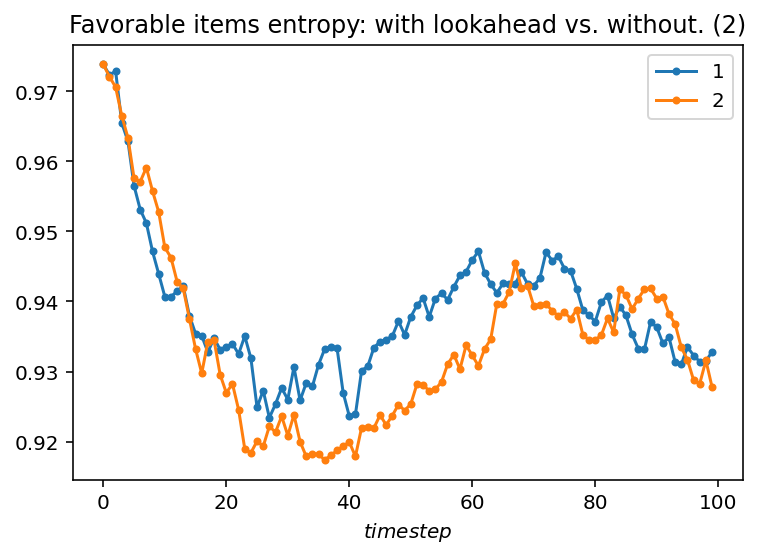

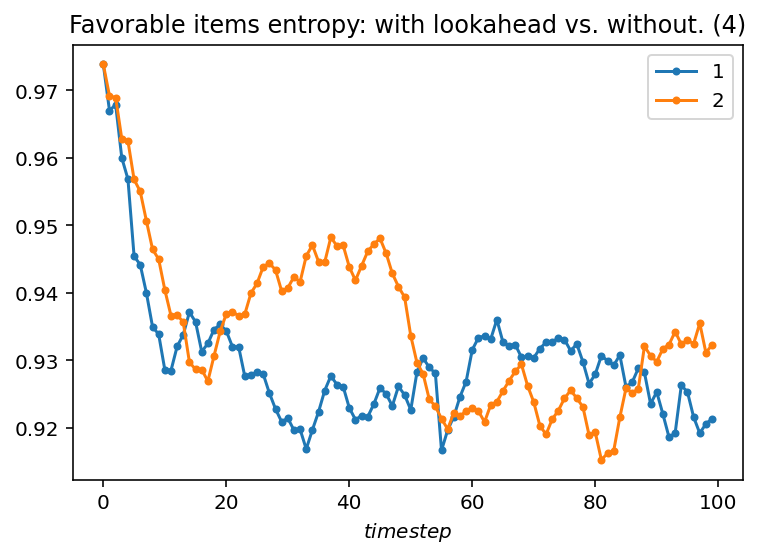

In [221]:
for i, dynamic_val in enumerate([0, 1, 2, 4]):
  plot_graphs(*[list(dynamic_vals_results_w_lookahead.values())[i],
                list(dynamic_vals_results_wo_lookahead.values())[i]], title=f'Favorable items entropy: with lookahead vs. without. ({dynamic_val})')

In [ ]:
import collections

class SocialCyclesTopics(Topics):
  def __init__(
      self,
      num_topics,
      num_users,
      num_items,
      rating_frequency=1.0,
      num_init_ratings=0,
      noise=0.0,
      topic_change=0.0,
      memory_length=0,
      boredom_threshold=0,
      boredom_penalty=0.0,
      satiation_factor=0.0,
      satiation_decay=0.0,
      satiation_noise=0.0,
      user_dist_choice='uniform',
      initial_sampling='uniform',
      shift_steps=1,
      shift_frequency=0.0,
      shift_weight=0.0,
      user_bias_type='none',
      item_bias_type='none', 
      num_social_cycles=10,
      ):
      super().__init__(
          num_topics,
          num_users,
          num_items,
          rating_frequency=1.0,
          num_init_ratings=0,
          noise=0.0,
          topic_change=0.0,
          memory_length=0,
          boredom_threshold=0,
          boredom_penalty=0.0,
          satiation_factor=0.0,
          satiation_decay=0.0,
          satiation_noise=0.0,
          user_dist_choice='uniform',
          initial_sampling='uniform',
          shift_steps=1,
          shift_frequency=0.0,
          shift_weight=0.0,
          user_bias_type='none',
          item_bias_type='none'
      )

      self._num_social_cycles = num_social_cycles
  
  def _reset_state(self):
    self._users_cycles = self._init_random.choice(self._num_social_cycles, size=self._num_users)
    return super()._reset_state()

  # def _reset_state(self):
  #   if self._user_bias_type == 'normal':
  #       self._user_biases = self._init_random.normal(loc=0., scale=0.5, size=self._num_users)
  #   elif self._user_bias_type == 'power':
  #       self._user_biases = 1 - self._init_random.power(5, size=self._num_users)
  #   elif self._user_bias_type == 'none':
  #       self._user_biases = np.zeros(self._num_users)
  #   else:
  #       print('User bias distribution is not supported')

  #   if self._item_bias_type == 'normal':
  #       self._item_biases = self._init_random.normal(loc=0., scale=0.5, size=self._num_items)
  #   elif self._item_bias_type == 'power':
  #       self._item_biases = 1 - self._init_random.power(5, size=self._num_users)
  #   elif self._item_bias_type == 'none':
  #       self._item_biases = np.zeros(self._num_items)
  #   else:
  #       print('Item bias distribution is not supported')

  #   self._offset = 0
  #   self._satiations = np.zeros((self._num_users, self._num_topics))
  #   self._user_preferences = self._init_random.uniform(low=0.5, high=5.5, \
  #                                                      size=(self._num_users, self._num_topics))
  #   self._item_topics = self._init_random.choice(self._num_topics, size=self._num_items)
  #   self._users = collections.OrderedDict((user_id, np.zeros(0)) \
  #                                         for user_id in range(self._num_users))
  #   self._items = collections.OrderedDict((item_id, np.zeros(0)) \
  #                                         for item_id in range(self._num_items))   
    

env = SocialCyclesTopics(
    num_topics=NUM_TOPICS,
    num_users=NUM_USERS,
    num_items=NUM_ITEMS,
    rating_frequency=RATING_FREQ,
    num_init_ratings=NUM_INIT_RATING,
    topic_change=TOPIC_CHANGE,
    num_social_cycles=10,
)
env.reset()  # Why it does not call the parent methods _rate_item et cetera?!?! TODO: need to check it, we cant continue without it!

**Discussion**:
* We can see that with the entropy lookahead, we can achieve better entropy for some of the dynamic values (2), but for other not (1,3,4).\
This results were taken on a mean of 10 repeats with different seed, on a 100x100 users-items matrix with 10 topics. We think that more repeats n a larger problem is needed to deduce definetive results. 
* I expect the effect will be even greater with the social cycles env, because it will model the echo effect of different users on each other. I think roughly it will increase the Popolarity bias in order of the size of the social cycle, but it's hard to tell a-priori.
* Unfortunately, We can't make the new env ready on time, So we'll present this idea to course staff as a direction for final project.  

Finally, describe briefly the challenges you expect to encounter if your lookahead approach would be used in a realistic setting (in which you would not be able to a simulator to correctly anticipate the outcomes of recommending at the next step).

**Answer:**\
This method is not possible in a real scenario since it depends on knowing the complete distribution over users ratings in the future. \
We could, hypothetically, to try to eppximated the entropy, using some sort of regression based on past observations, and then start at some point, say, after the regressor (neural network, Linear, etc.) has converged to some level, start using it as an estimator for the next step entropy.\
However, as we saw, I think that since the data is not i.i.d w.r.t cosecutive samples, finding such regressor will be very challenging.